In [49]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns

from lib.model import FNO1d
from lib.utils import relative_l2_error, calculate_errors
from lib.dataset import PDEDatasetAll2All

In [50]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [51]:
torch.manual_seed(0)
np.random.seed(0)

In [52]:
DEVICE = "cpu"

In [53]:
modes = 16
width = 64
layers = 4
fno = FNO1d(modes, width, layers).to(DEVICE)  # model
fno.load_state_dict(torch.load("models/tfno_model.pth", weights_only=True,  map_location=torch.device('cpu')))

<All keys matched successfully>

In [54]:
time_pairs = [(0, 4)]
dataset_low_eps = PDEDatasetAll2All(
    "data/OOD_LOW_E_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
)

errors_low_eps, ood_relative_l2_t1 = calculate_errors(fno, dataset_low_eps)

print(
    rf"OOD (low Epsilon) relative L2 error (u_0 -> u(t=1.0)): {ood_relative_l2_t1:.4f}"
)

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

OOD (low Epsilon) relative L2 error (u_0 -> u(t=1.0)): 0.3445


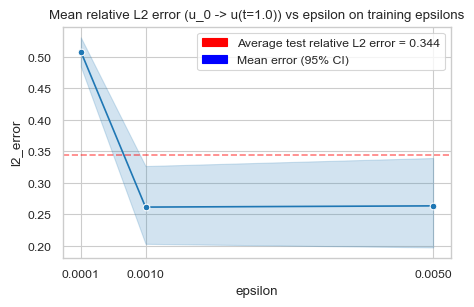

In [55]:
# plot mean_error_eps
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=errors_low_eps, x="epsilon", y="l2_error", ax=ax, marker="o")
# set ticks to epsilon
ax.set_xticks(errors_low_eps["epsilon"].unique())

plt.axhline(y=ood_relative_l2_t1, color="r", linestyle="--", alpha=0.5)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=f"Average test relative L2 error = {ood_relative_l2_t1:.3f}"),
        Patch(facecolor="b", edgecolor="b", label="Mean error (95% CI)"),
    ]
)

plt.title("Mean relative L2 error (u_0 -> u(t=1.0)) vs epsilon on training epsilons")
plt.savefig("figures/ood_low_ep.png", dpi=300)
plt.show()

In [56]:
time_pairs = [(0, 4)]
dataset_ood_hf = PDEDatasetAll2All(
    "data/OOD_HF_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
)

errors_hf, ood_hf_relative_l2_t1 = calculate_errors(fno, dataset_ood_hf)

print(rf"OOD (HF) relative L2 error (u_0 -> u(t=1.0)): {ood_hf_relative_l2_t1:.4f}")

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

OOD (HF) relative L2 error (u_0 -> u(t=1.0)): 0.3722


In [57]:
errors_hf

,dt,l2_error,epsilon
0,0.02,0.319184,0.02
1,0.02,0.319184,0.02
2,0.02,0.319184,0.02
3,0.05,0.647696,0.05
4,0.02,0.319184,0.02
5,0.02,0.319184,0.02
6,0.10,0.148162,0.10
7,0.10,0.148162,0.10
8,0.02,0.319184,0.02
9,0.05,0.647696,0.05


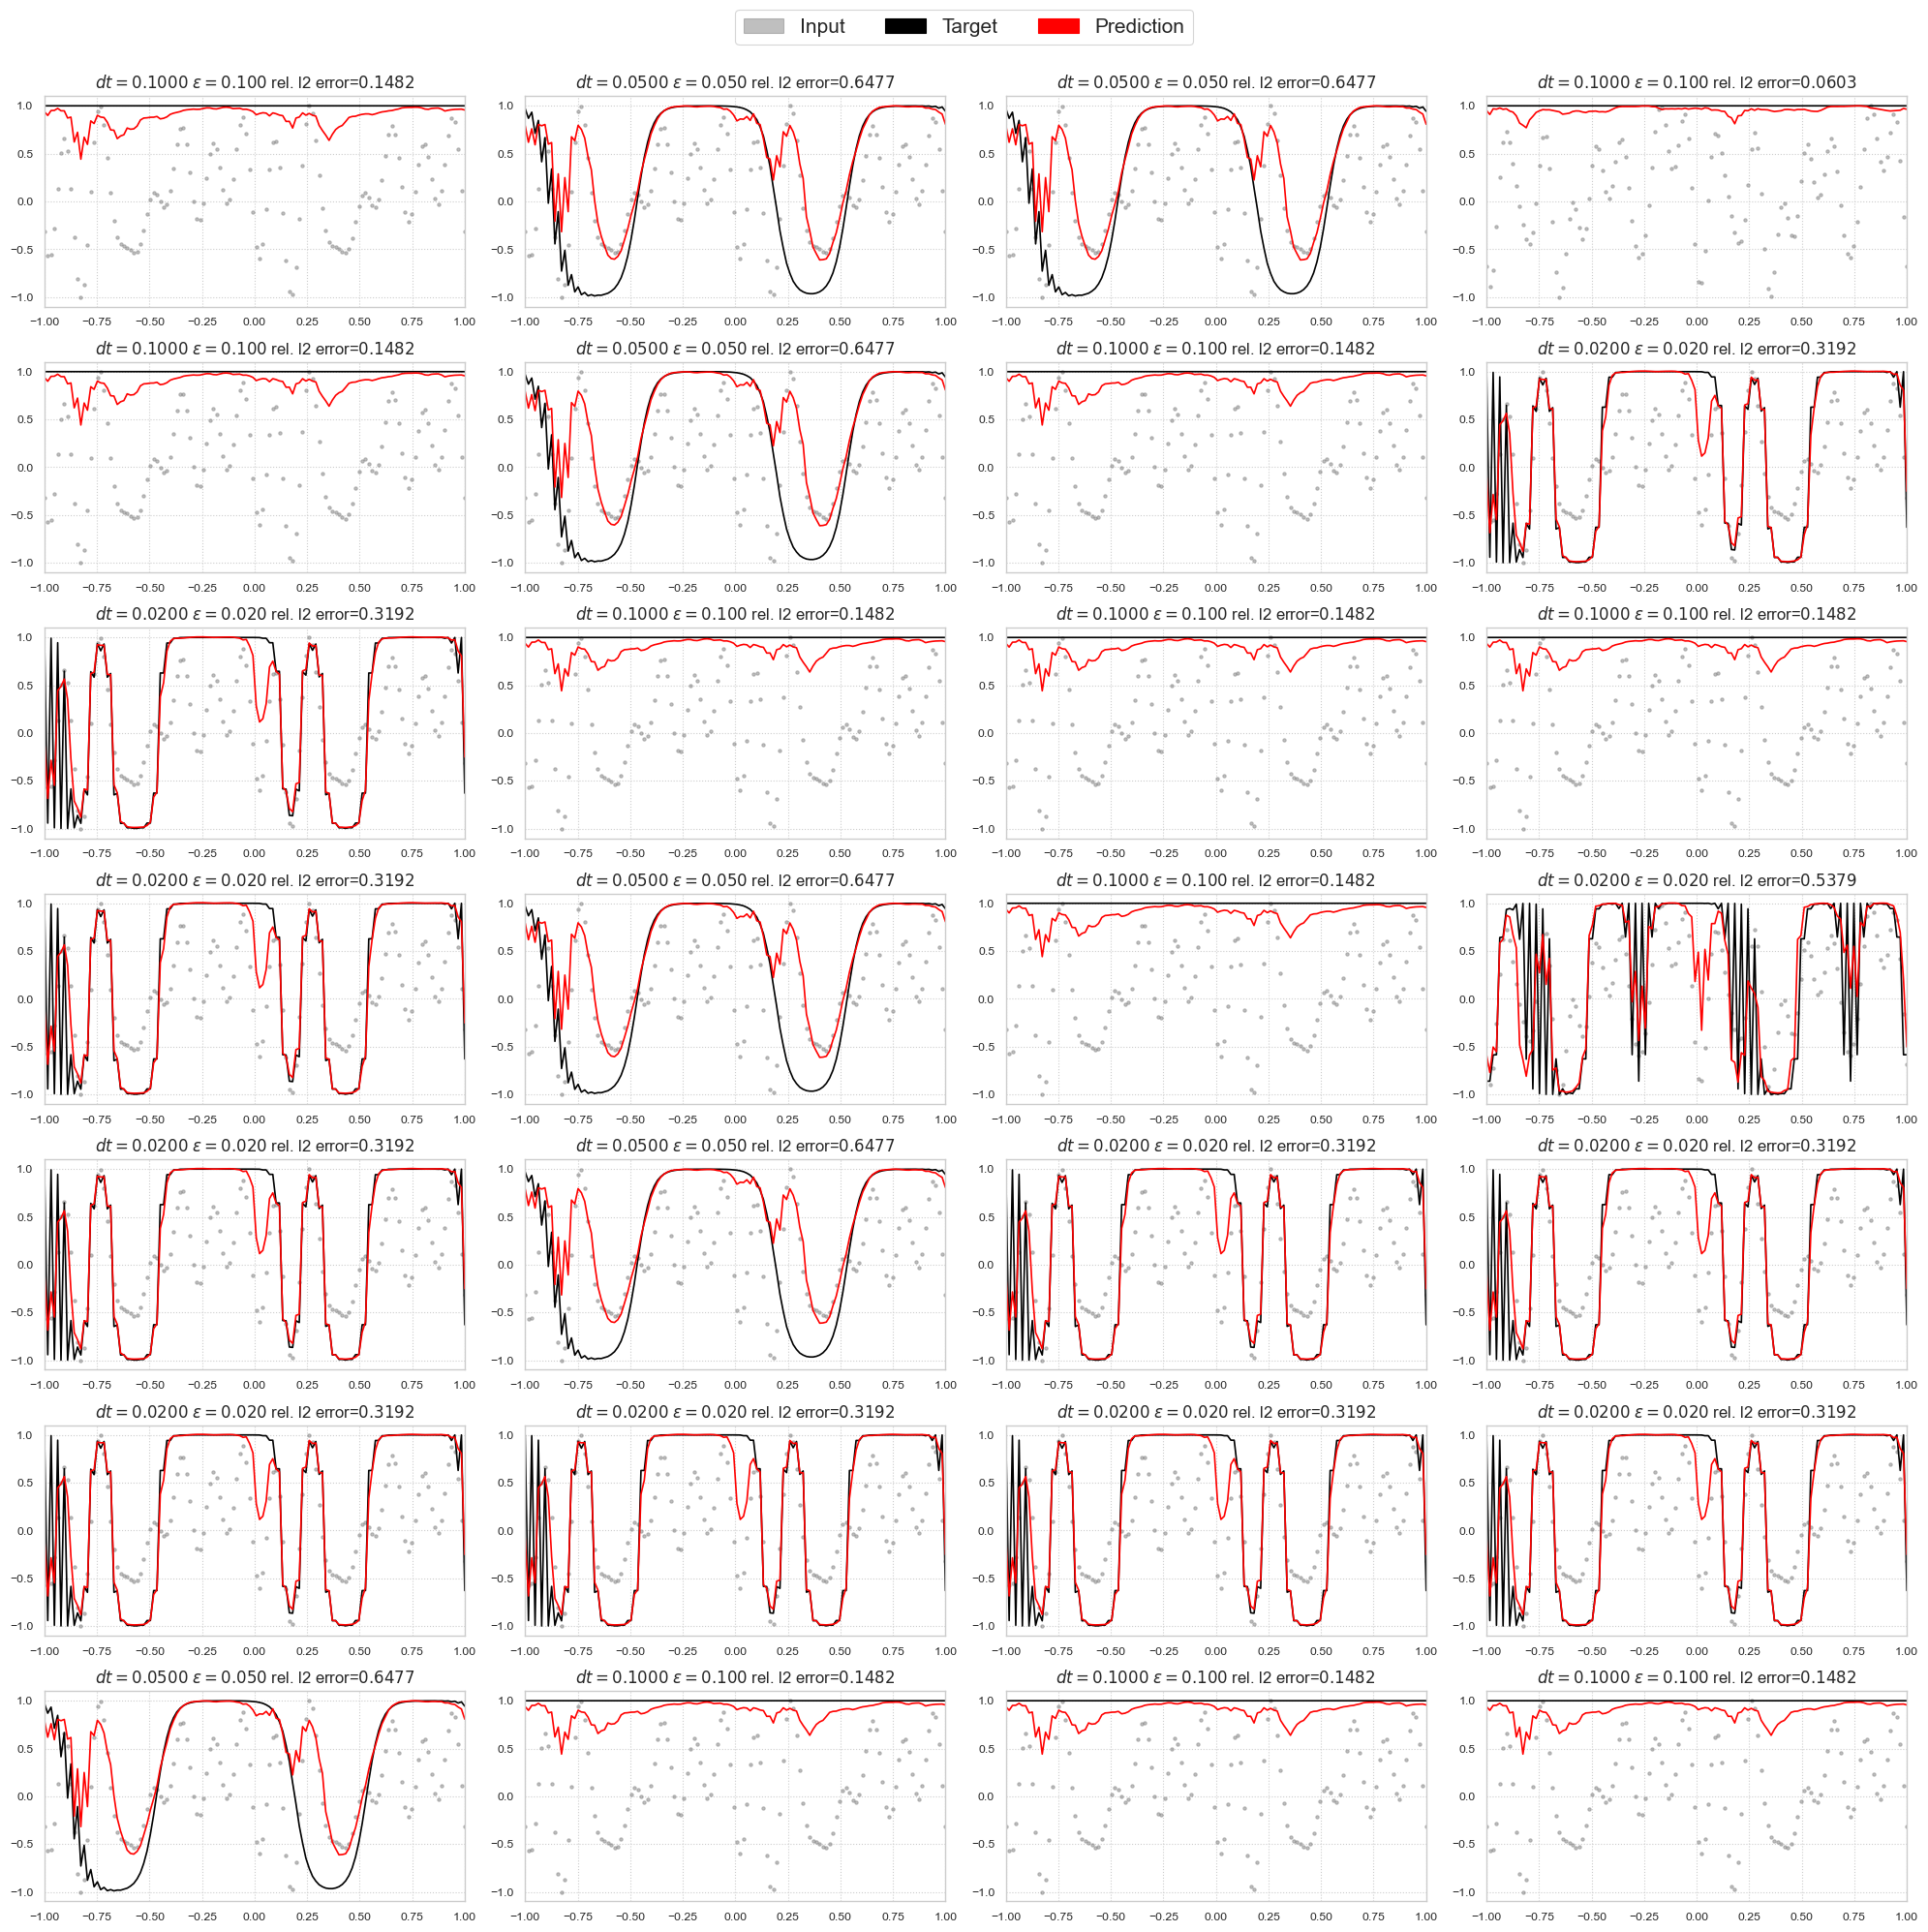

In [58]:
sampler = DataLoader(dataset_ood_hf, batch_size=4, shuffle=True)
fig, axs = plt.subplots(7, 4, figsize=(20, 20))

fno.eval()
lines = None
for i, (ax_rows, (time_delta, eps, input, target)) in enumerate(zip(axs, sampler)):
    input_copy = input.clone()

    with torch.no_grad():
        prediction = fno(input, time_delta, eps)

    target = target

    for j, p in enumerate(prediction):
        epsilon = eps[j].item()
        re_l2_error = relative_l2_error(p.squeeze(-1), target[j], dim=-1)

        ax = ax_rows[j]

        # set limits
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1.1, 1.1)

        ax.set_title(
            rf"$dt={time_delta[j].item():.4f}$ $\epsilon={epsilon:.3f}$ rel. l2 error=${re_l2_error:.4f}$",
            fontsize=12,
        )

        x_grid = np.linspace(-1, 1, 128)

        l1 = ax.scatter(
            x_grid,
            input_copy[j, :, 0],
            label="Input",
            alpha=0.5,
            color="gray",
            marker=".",
        )

        l2 = ax.plot(x_grid, target[j], label="Target", color="black")
        l3 = ax.plot(x_grid, p, label="Prediction", color="red")

        ax.grid(True, which="both", ls=":")

        if i == 0 and j == 0:
            lines = [l1, l2, l3]

labels = [l1.get_label(), l2[0].get_label(), l3[0].get_label()]
handles = []
for group_idx in range(len(labels)):
    # Create a simple patch that is the correct colour
    try:
        colour = lines[group_idx][0].get_color()
        opac = lines[group_idx][0].get_alpha()
    except TypeError:
        colour = lines[group_idx].get_facecolor()
        opac = lines[group_idx].get_alpha()
    handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True, alpha=opac))
# Acutally create our figure legend, using the handles and labels
fig.legend(
    handles=handles, labels=labels, loc="upper center", ncol=len(labels), fontsize=15
)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig("figures/ac_ood_hf_examples.png", dpi=300)
plt.show()

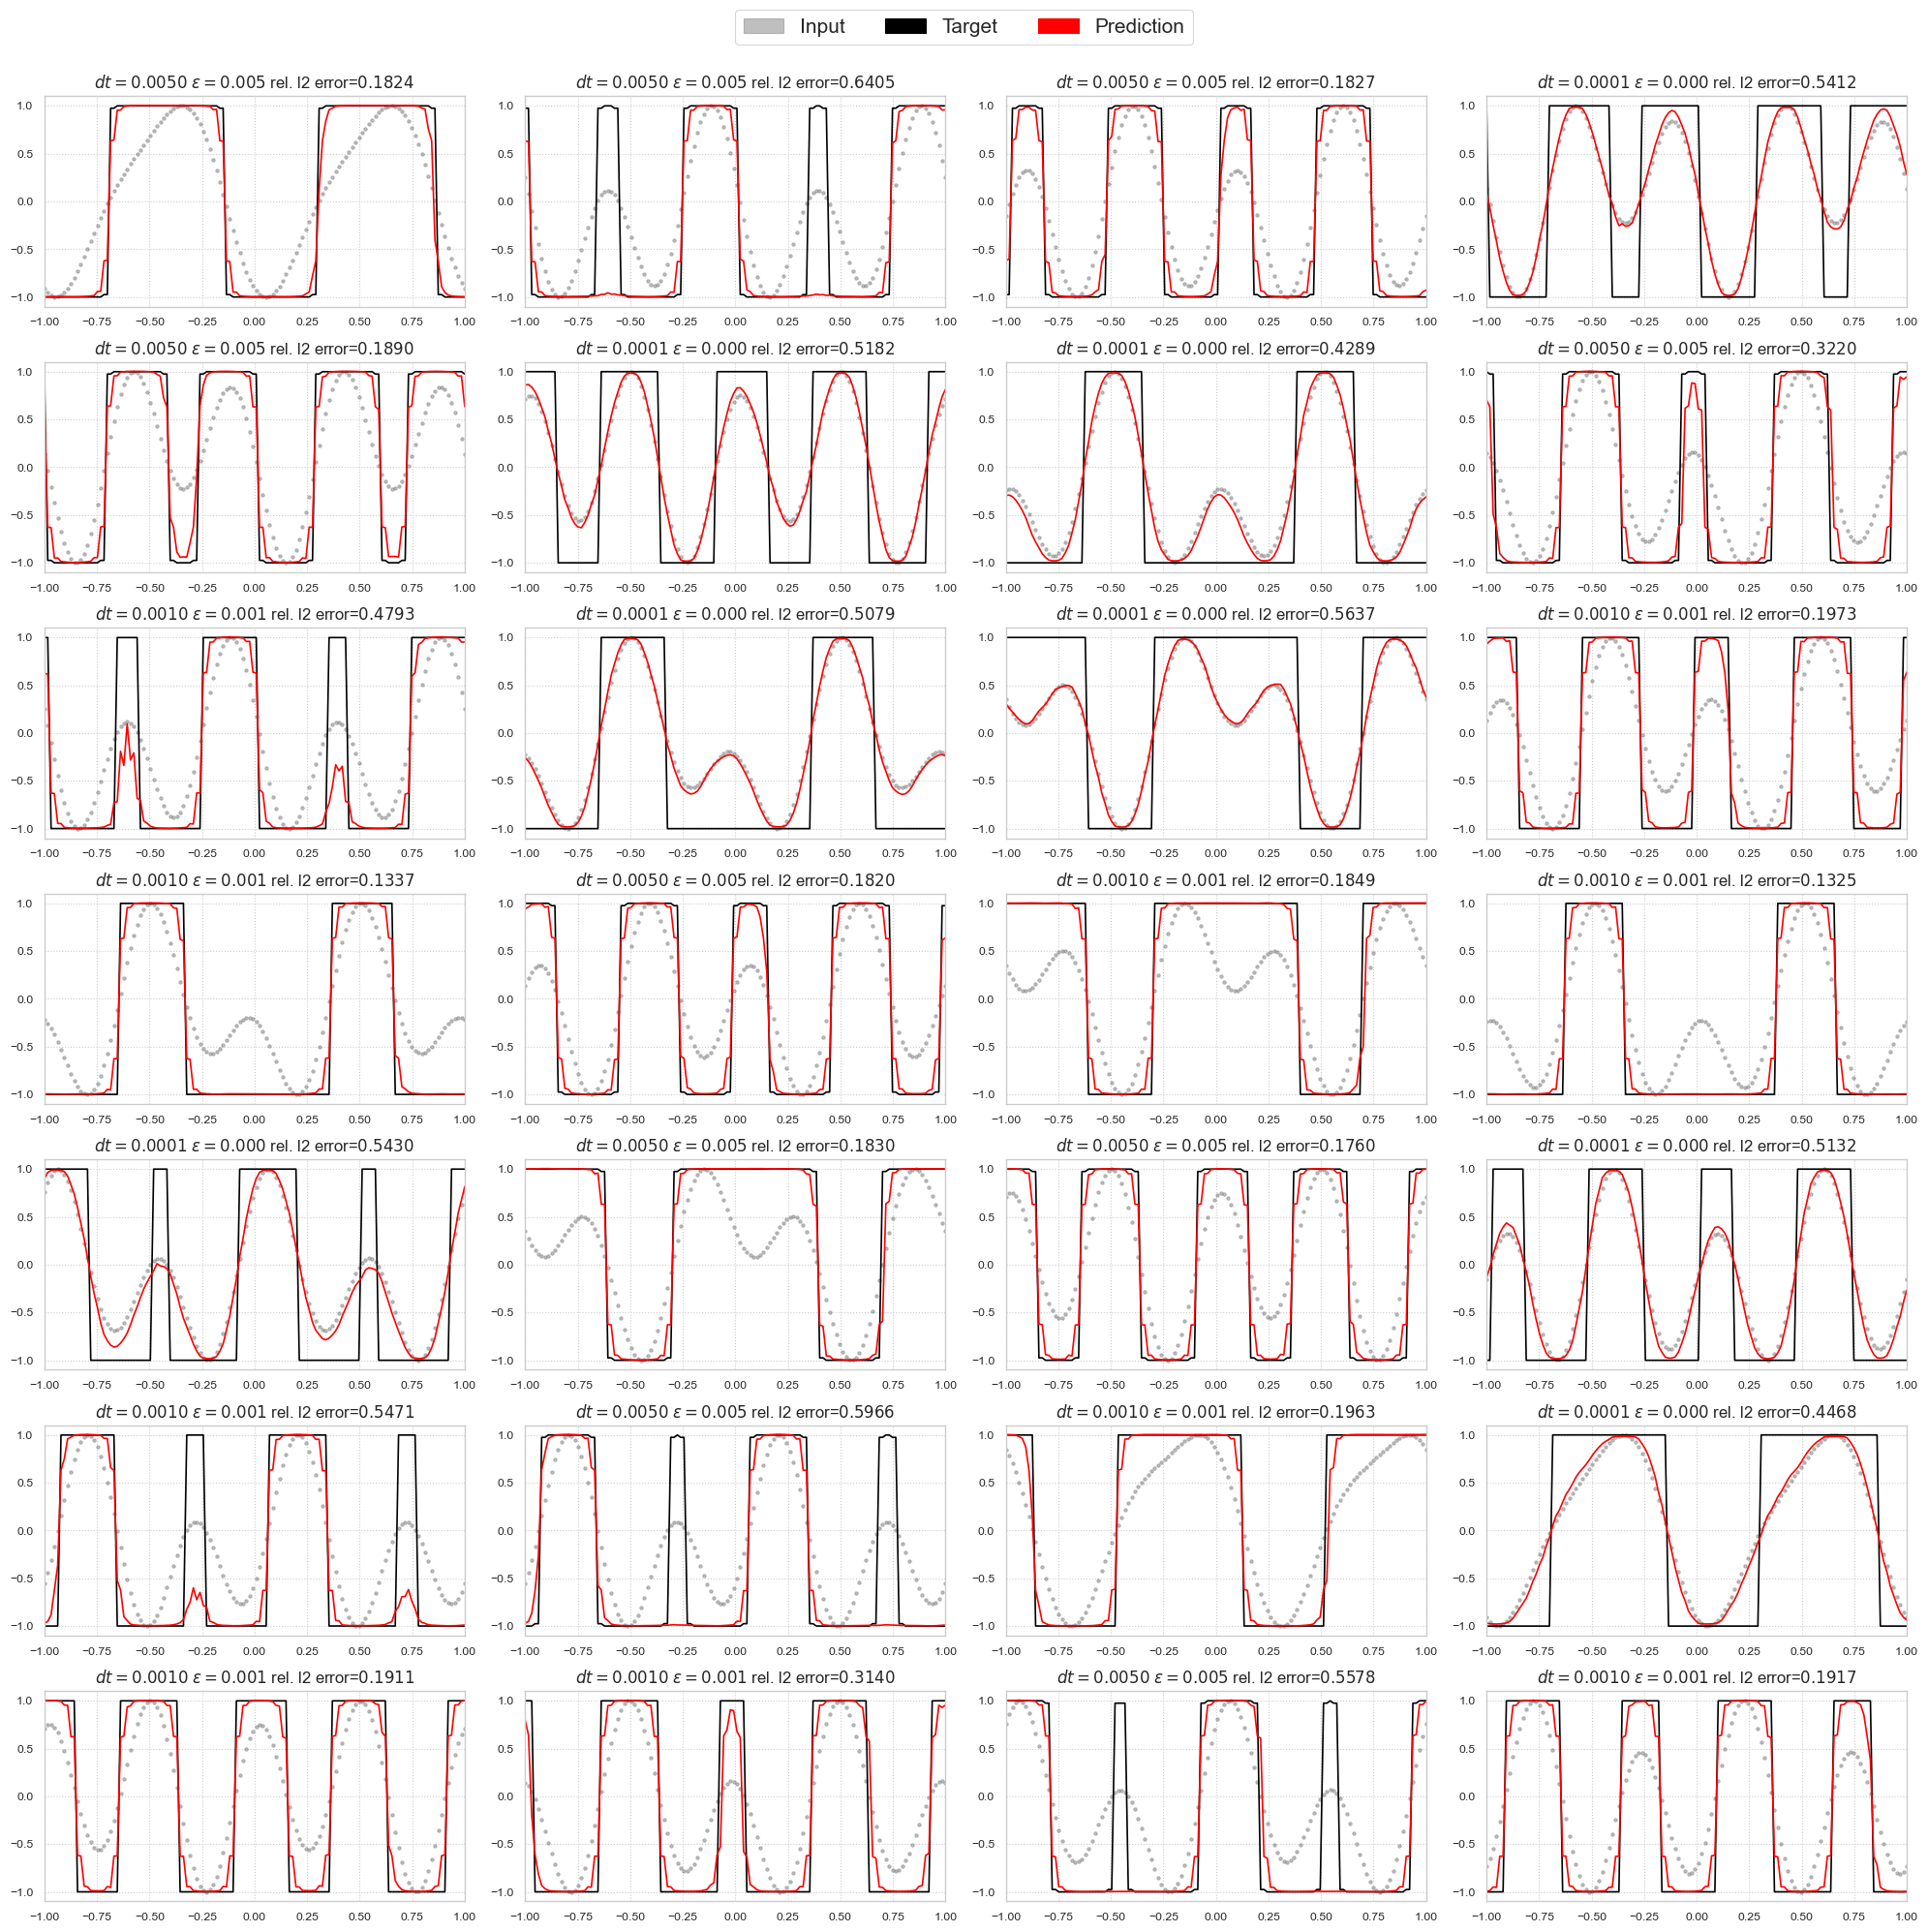

In [59]:
sampler = DataLoader(dataset_low_eps, batch_size=4, shuffle=True)
fig, axs = plt.subplots(7, 4, figsize=(20, 20))

fno.eval()
lines = None
for i, (ax_rows, (time_delta, eps, input, target)) in enumerate(zip(axs, sampler)):
    input_copy = input.clone()

    with torch.no_grad():
        prediction = fno(input, time_delta, eps)

    target = target

    for j, p in enumerate(prediction):
        epsilon = eps[j].item()
        re_l2_error = relative_l2_error(p.squeeze(-1), target[j], dim=-1)

        ax = ax_rows[j]

        # set limits
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1.1, 1.1)

        ax.set_title(
            rf"$dt={time_delta[j].item():.4f}$ $\epsilon={epsilon:.3f}$ rel. l2 error=${re_l2_error:.4f}$",
            fontsize=12,
        )

        x_grid = np.linspace(-1, 1, 128)

        l1 = ax.scatter(
            x_grid,
            input_copy[j, :, 0],
            label="Input",
            alpha=0.5,
            color="gray",
            marker=".",
        )

        l2 = ax.plot(x_grid, target[j], label="Target", color="black")
        l3 = ax.plot(x_grid, p, label="Prediction", color="red")

        ax.grid(True, which="both", ls=":")

        if i == 0 and j == 0:
            lines = [l1, l2, l3]

labels = [l1.get_label(), l2[0].get_label(), l3[0].get_label()]
handles = []
for group_idx in range(len(labels)):
    # Create a simple patch that is the correct colour
    try:
        colour = lines[group_idx][0].get_color()
        opac = lines[group_idx][0].get_alpha()
    except TypeError:
        colour = lines[group_idx].get_facecolor()
        opac = lines[group_idx].get_alpha()
    handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True, alpha=opac))
# Acutally create our figure legend, using the handles and labels
fig.legend(
    handles=handles, labels=labels, loc="upper center", ncol=len(labels), fontsize=15
)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig("figures/ac_ood_low_eps_examples.png", dpi=300)
plt.show()